In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
#os.chdir('D:/Traffic_Sign_Recognition')
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [2]:
!pip install tensorflow==2.13.0 keras==2.13.1 tensorflow-addons==0.21.0

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
data = []
labels = []
classes = 3
cur_path = '/content/drive/MyDrive/work'

In [6]:
cur_path

'/content/drive/MyDrive/work'

In [7]:
# Map class labels to folder names
class_mapping = {
    0: "Adenocarcinoma cases",
    1: "Largecell Carcinoma cases",
    2: "Normal cases"

}

data = []
labels = []

cur_path = "/content/drive/MyDrive/work/"
train_path = os.path.join(cur_path)

for class_label, folder_name in class_mapping.items():
    path = os.path.join(train_path, folder_name)
    if not os.path.exists(path):
        print(f"Class {class_label} directory not found: {path}")
        continue

    print(f"Processing {folder_name} (Class {class_label})...")
    images = os.listdir(path)
    for image_name in images:
        try:
            image_path = os.path.join(path, image_name)
            image = Image.open(image_path)
            image = image.resize((30, 30))
            image = np.array(image)
            data.append(image)
            labels.append(class_label)
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

print(f"Processed {len(data)} images.")

Processing Adenocarcinoma cases (Class 0)...
Processing Largecell Carcinoma cases (Class 1)...
Processing Normal cases (Class 2)...
Processed 1098 images.


In [8]:
data = np.array(data)
labels = np.array(labels)

In [9]:
print(data.shape, labels.shape)

(1098, 30, 30, 3) (1098,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(878, 30, 30, 3) (220, 30, 30, 3) (878,) (220,)


(-0.5, 29.5, 29.5, -0.5)

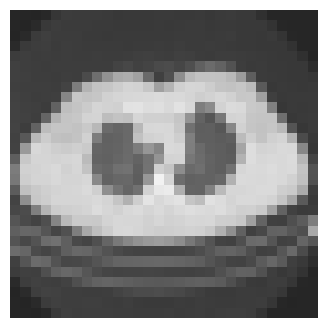

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

In [13]:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [15]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [16]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 120
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8       #6,7,8,9,10,11,12
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


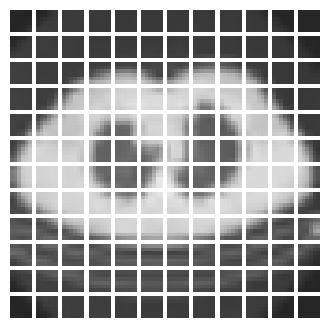

In [18]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [20]:
input_shape = (30, 30, 3)

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# vit_classifier = create_vit_classifier()


In [22]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/120
4/4 [==============================] - 214s 43s/step - loss: 11.8570 - accuracy: 0.4304 - top-5-accuracy: 1.0000 - val_loss: 4.0295 - val_accuracy: 0.4432 - val_top-5-accuracy: 1.0000
Epoch 2/120
4/4 [==============================] - 129s 25s/step - loss: 4.0776 - accuracy: 0.4177 - top-5-accuracy: 1.0000 - val_loss: 1.0209 - val_accuracy: 0.4432 - val_top-5-accuracy: 1.0000
Epoch 3/120
4/4 [==============================] - 126s 30s/step - loss: 1.7119 - accuracy: 0.5127 - top-5-accuracy: 1.0000 - val_loss: 1.4683 - val_accuracy: 0.4773 - val_top-5-accuracy: 1.0000
Epoch 4/120
4/4 [==============================] - 122s 29s/step - loss: 1.7898 - accuracy: 0.5519 - top-5-accuracy: 1.0000 - val_loss: 1.1239 - val_accuracy: 0.2841 - val_top-5-accuracy: 1.0000
Epoch 5/120
4/4 [==============================] - 132s 26s/step - loss: 1.4614 - accuracy: 0.4684 - top-5-accuracy: 1.0000 - val_loss: 0.8605 - val_accuracy: 0.6364 - val_top-5-accuracy: 1.0000
Epoch 6/120
4/4 [=======

In [23]:
#history.history ??
history.history.keys()
print(history.history['accuracy'])

[0.4303797483444214, 0.4177215099334717, 0.5126582384109497, 0.551898717880249, 0.4683544337749481, 0.5367088317871094, 0.5924050807952881, 0.594936728477478, 0.6025316715240479, 0.6101265549659729, 0.6430379748344421, 0.6025316715240479, 0.6164556741714478, 0.6417721509933472, 0.6379746794700623, 0.646835446357727, 0.6658228039741516, 0.6405063271522522, 0.6379746794700623, 0.6582278609275818, 0.6696202754974365, 0.6518987417221069, 0.6696202754974365, 0.6886075735092163, 0.6886075735092163, 0.6974683403968811, 0.6936708688735962, 0.6848101019859314, 0.6873417496681213, 0.7253164649009705, 0.6936708688735962, 0.6810126304626465, 0.6936708688735962, 0.7101265788078308, 0.7253164649009705, 0.6949366927146912, 0.7151898741722107, 0.7189873456954956, 0.7227848172187805, 0.7240506410598755, 0.6962025165557861, 0.7316455841064453, 0.7050632834434509, 0.7227848172187805, 0.7430379986763, 0.7202531695365906, 0.7329114079475403, 0.7329114079475403, 0.7481012940406799, 0.7493671178817749, 0.768

In [24]:
history.history

{'loss': [11.857020378112793,
  4.077569961547852,
  1.7118561267852783,
  1.7898279428482056,
  1.4613993167877197,
  1.1689287424087524,
  1.0146342515945435,
  1.0030369758605957,
  1.0024267435073853,
  0.9164365530014038,
  0.8839397430419922,
  0.9281355142593384,
  0.9107050895690918,
  0.8985469937324524,
  0.8320286870002747,
  0.8852687478065491,
  0.8369277119636536,
  0.8230361938476562,
  0.8669263124465942,
  0.8398798108100891,
  0.7651524543762207,
  0.8126342296600342,
  0.8207594752311707,
  0.7909705638885498,
  0.751393735408783,
  0.7429580092430115,
  0.7508754134178162,
  0.7570406794548035,
  0.7538858652114868,
  0.7234718799591064,
  0.7341526746749878,
  0.7426212430000305,
  0.764894425868988,
  0.6909881830215454,
  0.6732279658317566,
  0.721211850643158,
  0.7177484035491943,
  0.6704475283622742,
  0.6788058876991272,
  0.6771023869514465,
  0.6881354451179504,
  0.6931519508361816,
  0.696749746799469,
  0.643923819065094,
  0.6526509523391724,
  0.6689

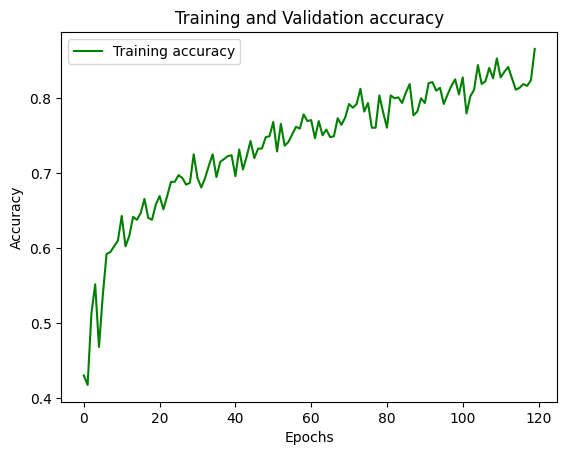

epochs:  120  heads:  8


In [25]:
import matplotlib.pyplot as plt

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,num_epochs)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
#plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('epochs: ',num_epochs,' heads: ',num_heads)

epochs:  120  heads:  8


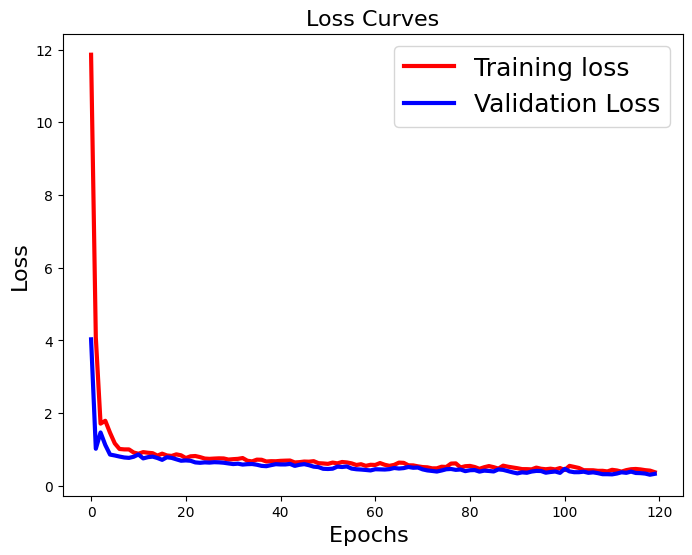

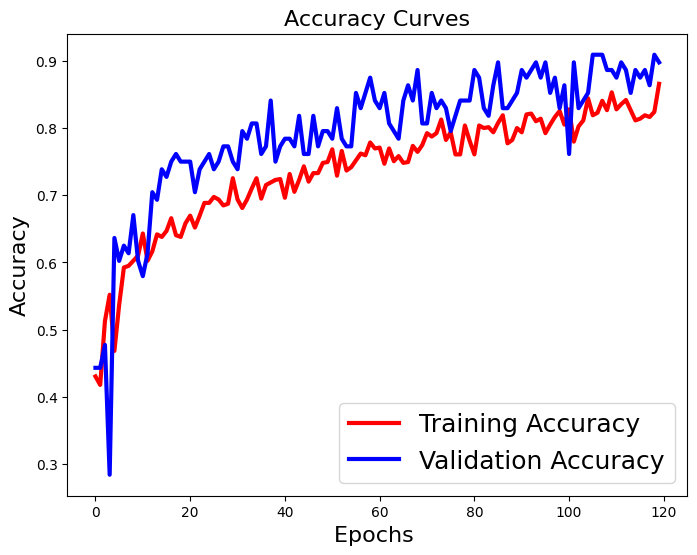

In [26]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

print('epochs: ',num_epochs,' heads: ',num_heads)

In [27]:
%ls

drive/  sample_data/


In [28]:
vit_classifier.save_weights('/content/drive/MyDrive/work')

In [29]:
vit_classifier.save('vit_model')

In [36]:
vit_model = create_vit_classifier()

In [37]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
print(y_test)
x_outputs = vit_model.predict(data)

[2 0 1 1 1 1 2 2 1 2 1 2 2 2 1 2 2 0 1 2 1 2 1 1 1 2 2 0 2 1 2 2 1 1 1 1 1
 1 1 2 0 2 1 2 2 1 0 1 1 2 1 1 1 1 1 1 2 2 1 2 0 1 1 1 2 0 1 1 1 2 1 1 2 1
 1 1 2 2 1 1 1 2 0 0 2 1 2 1 2 2 1 1 2 1 1 1 1 2 1 0 1 2 2 1 1 1 1 2 2 0 1
 1 2 2 1 0 1 1 1 0 2 2 1 2 2 1 2 1 2 1 1 2 1 1 2 0 1 1 2 1 1 0 1 2 1 1 1 1
 2 2 0 1 2 0 1 2 2 1 1 2 2 1 1 2 1 1 2 2 1 2 2 2 2 2 0 1 2 0 1 2 0 1 1 2 1
 1 2 2 1 1 2 1 1 2 2 1 2 2 2 2 1 2 1 1 2 2 1 1 1 1 2 0 1 2 1 2 2 1 1 2]
35/35 [==============================] - 38s 1s/step


In [31]:
X_test

array([[[[ 38,  38,  38],
         [ 38,  38,  38],
         [ 42,  42,  42],
         ...,
         [ 40,  40,  40],
         [ 38,  38,  38],
         [ 38,  38,  38]],

        [[ 38,  38,  38],
         [ 41,  41,  41],
         [ 44,  44,  44],
         ...,
         [ 43,  43,  43],
         [ 40,  40,  40],
         [ 38,  38,  38]],

        [[ 41,  41,  41],
         [ 43,  43,  43],
         [ 43,  43,  43],
         ...,
         [ 43,  43,  43],
         [ 43,  43,  43],
         [ 40,  40,  40]],

        ...,

        [[ 41,  41,  41],
         [ 44,  44,  44],
         [ 44,  44,  44],
         ...,
         [ 43,  43,  43],
         [ 43,  43,  43],
         [ 40,  40,  40]],

        [[ 38,  38,  38],
         [ 42,  42,  42],
         [ 44,  44,  44],
         ...,
         [ 43,  43,  43],
         [ 41,  41,  41],
         [ 38,  38,  38]],

        [[ 38,  38,  38],
         [ 38,  38,  38],
         [ 41,  41,  41],
         ...,
         [ 40,  40,  40],
        

In [32]:
import seaborn as sns

In [38]:
predicted_values = []

for i in x_outputs:
    predicted_values.append(i.argmax(axis=0))

In [39]:

print(y_test.shape, x_outputs.shape)

print(y_test)
print(x_outputs)

(220,) (1098, 3)
[2 0 1 1 1 1 2 2 1 2 1 2 2 2 1 2 2 0 1 2 1 2 1 1 1 2 2 0 2 1 2 2 1 1 1 1 1
 1 1 2 0 2 1 2 2 1 0 1 1 2 1 1 1 1 1 1 2 2 1 2 0 1 1 1 2 0 1 1 1 2 1 1 2 1
 1 1 2 2 1 1 1 2 0 0 2 1 2 1 2 2 1 1 2 1 1 1 1 2 1 0 1 2 2 1 1 1 1 2 2 0 1
 1 2 2 1 0 1 1 1 0 2 2 1 2 2 1 2 1 2 1 1 2 1 1 2 0 1 1 2 1 1 0 1 2 1 1 1 1
 2 2 0 1 2 0 1 2 2 1 1 2 2 1 1 2 1 1 2 2 1 2 2 2 2 2 0 1 2 0 1 2 0 1 1 2 1
 1 2 2 1 1 2 1 1 2 2 1 2 2 2 2 1 2 1 1 2 2 1 1 1 1 2 0 1 2 1 2 2 1 1 2]
[[ 0.8322159  -0.40994143  0.42935744]
 [-0.9019532  -0.16049038  0.9879879 ]
 [ 1.5147518  -1.4793448   0.23304543]
 ...
 [ 0.40043932  0.167279   -0.00457299]
 [ 0.32824692  0.09585574 -0.00566733]
 [ 0.70248073 -0.11407038  0.21909526]]


[[ 89   0  32]
 [274   3 284]
 [313   4  99]]


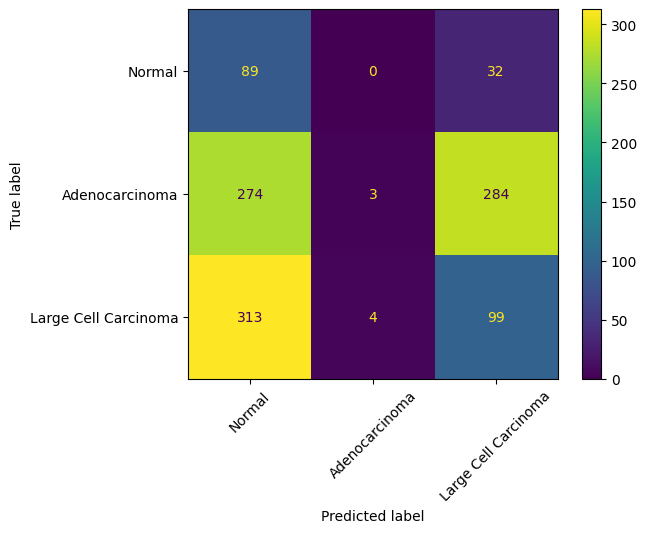

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

# __label = ['Adenocarcinoma cases', 'Largecell Carcinoma cases', 'Normal cases']

cm = confusion_matrix(labels, predicted_values)

print(cm)

disp = ConfusionMatrixDisplay(cm,display_labels=['Normal', 'Adenocarcinoma', 'Large Cell Carcinoma'])
disp.plot(xticks_rotation=45)


In [41]:
print(cm)

[[ 89   0  32]
 [274   3 284]
 [313   4  99]]


In [42]:
acc_matrix = []
for i in cm:
    tmp = []
    for j in i:
        tmp.append(j/sum(i))
    acc_matrix.append(tmp)

In [43]:
print(np.matrix(acc_matrix))

[[0.73553719 0.         0.26446281]
 [0.48841355 0.00534759 0.50623886]
 [0.75240385 0.00961538 0.23798077]]


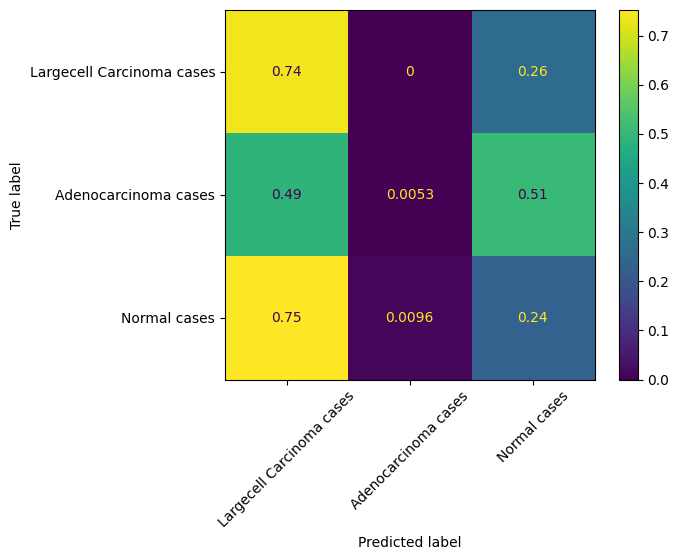

In [44]:
# disp = ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay(np.matrix(acc_matrix),display_labels=['Largecell Carcinoma cases','Adenocarcinoma cases', 'Normal cases'])

disp.plot(xticks_rotation=45)